In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score

Bayesian Ridge Regression Results:
Parameters (default): {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'lambda_init': None, 'max_iter': 300, 'tol': 0.001, 'verbose': False}
RMSE: 0.1790
Test MAE: 0.1449
Test MAPE: 2.78%
R² score: 0.6232786012212331
Outlier rate: 6.67%

Outlier Details:
       Date  True Cotacao  Predicted Cotacao  Lower Bound  Upper Bound  \
269  2022-6        5.2562           4.782934     4.515342     5.050526   
281  2023-6        4.7860           5.087855     4.820263     5.355448   

     Is Outlier  
269        True  
281        True  


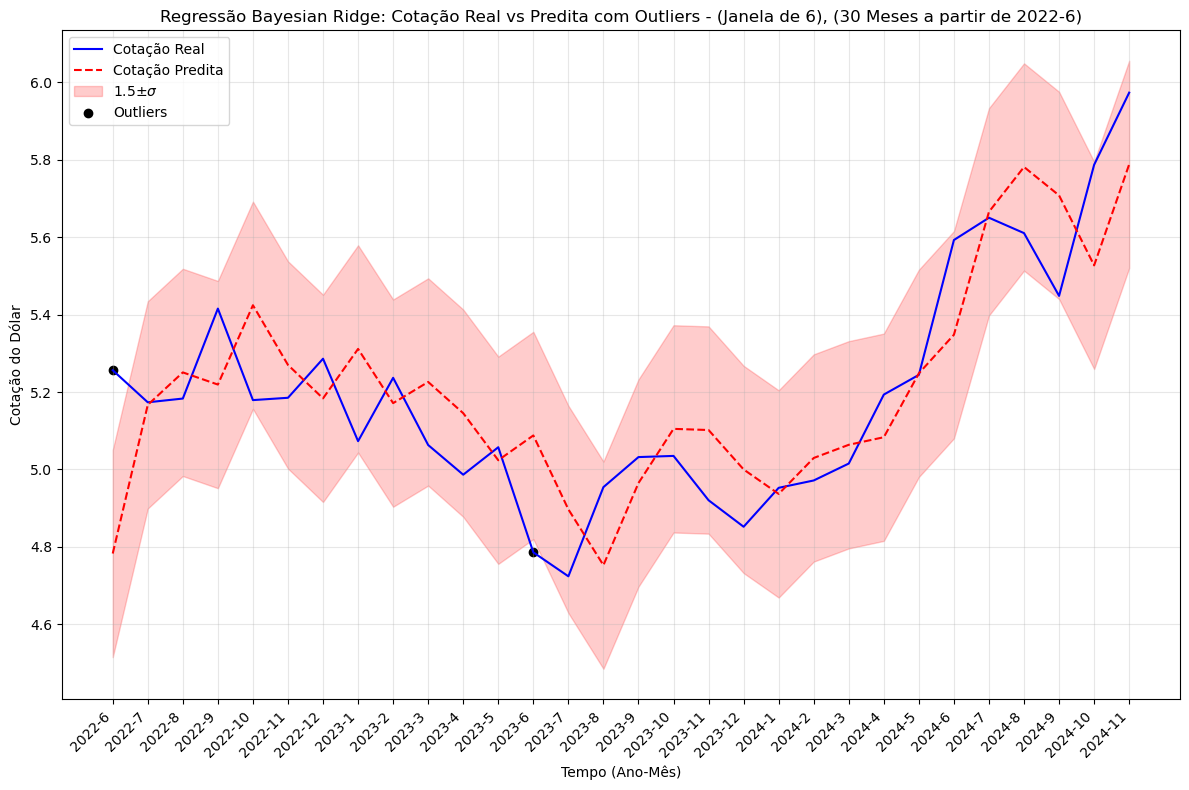

In [60]:
# Load data
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
         'divida_pp', 'fed_rate']]

# Create lag features (n months shift)
n=6
for shift_val in range(1, n+1):
    for column in ['cotacao', 'ipca_acumulado', 'cpi', 'selic', 'divida_pp', 'fed_rate']:
        column_name = f'{column}_lag{shift_val}'
        df[column_name] = df[column].shift(shift_val)
        df.fillna(df[column].values[0], inplace=True) 

# Define features and target
X = df.drop(columns=['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
                     'divida_pp', 'fed_rate'])  # Use only n-month-shifted features
y = df['cotacao']

# Separar treino e teste preservando a ordem temporal
train_size = int(len(df) * 0.90) # Digite o número em meses se quiser
window = abs(train_size - int(len(df))) # abs(train_size - int(len(df))) for max left # Digite a quantidade de meses se quiser
X_train, X_test = X.loc[:train_size - 1], X.loc[train_size:train_size + window - 1]  
y_train, y_test = y.loc[:train_size - 1], y.loc[train_size:train_size + window - 1]

# Scale features with MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train Bayesian Ridge model
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train_scaled, y_train)

# Predictions for the test set
y_test_pred = bayesian_ridge.predict(X_test_scaled)

# Calculate metrics
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100  # Convert to percentage
rmse = root_mean_squared_error(y_test, y_test_pred)
outlier_rate = None  # Will calculate after uncertainty

# Calculate residuals and uncertainty 
residuals_test = y_test - y_test_pred
std_dev = np.std(residuals_test)
mul_std = 1.5
lower_bound = y_test_pred - mul_std * std_dev
upper_bound = y_test_pred + mul_std * std_dev

# Identify outliers
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)
outliers_df = pd.DataFrame({
    'Date': df.loc[train_size:train_size + window - 1]['ano'].astype(str) + '-' + df.loc[train_size:train_size + window - 1]['mes'].astype(str),
    'True Cotacao': y_test.values,
    'Predicted Cotacao': y_test_pred,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound,
    'Is Outlier': outliers_mask
})

outliers_df = outliers_df[outliers_df['Is Outlier']]
outlier_rate = (len(outliers_df) / len(y_test)) * 100  # Percentage of outliers

# Print results, focusing on MAE, MAPE, outlier rate, and trend
print("Bayesian Ridge Regression Results:")
print("Parameters (default):", bayesian_ridge.get_params())
print(f"RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
r2 = r2_score(y_test, y_test_pred)
print("R² score:", r2)
print(f"Outlier rate: {outlier_rate:.2f}%")
print(f"\nOutlier Details:")
print(outliers_df)

# Visualize results for the test period
plt.figure(figsize=(12, 8))  # Match your SVR plot's size
x_labels = df.loc[train_size:train_size + window - 1]['ano'].astype(str) + '-' + df.loc[train_size:train_size + window - 1]['mes'].astype(str)

plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_test_pred, label="Cotação Predita", color="red", linestyle="--")
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=rf"{mul_std}$\pm\sigma$")
plt.scatter(outliers_df['Date'], outliers_df['True Cotacao'], 
            color='black', marker='o', label="Outliers")

plt.xticks(rotation=45, ha='right')
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title(f"Regressão Bayesian Ridge: Cotação Real vs Predita com Outliers - (Janela de {n}), ({window} Meses a partir de {x_labels.values[0]})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Processed up to 2002-12
Processed up to 2003-12
Processed up to 2004-12
Processed up to 2005-12
Processed up to 2006-12
Processed up to 2007-12
Processed up to 2008-12
Processed up to 2009-12
Processed up to 2010-12
Processed up to 2011-12
Processed up to 2012-12
Processed up to 2013-12
Processed up to 2014-12
Processed up to 2015-12
Processed up to 2016-12
Processed up to 2017-12
Processed up to 2018-12
Processed up to 2019-12
Processed up to 2020-12
Processed up to 2021-12
Processed up to 2022-12
Processed up to 2023-12
Overall RMSE: 0.1901
Overall MAE: 0.1436
Overall MAPE: 4.67%
Overall R² score: 0.98
Outlier rate: 4.73%

Outlier Details:


,Date,True Cotacao,Predicted Cotacao,Lower Bound,Upper Bound
0,2002-2,2.3650,2.514447,2.403038,2.625857
1,2002-5,2.5180,2.330761,2.182365,2.479157
2,2002-6,2.8175,2.496869,2.334614,2.659124
3,2002-7,3.4600,2.783539,2.621016,2.946062
4,2002-8,3.0075,3.765224,3.519835,4.010613
5,2002-9,3.7600,3.091383,2.729606,3.453161
6,2015-3,3.1947,2.734969,2.392943,3.076994
7,2016-3,3.5925,4.044391,3.683289,4.405493
8,2018-10,3.7218,4.108367,3.732600,4.484134
9,2020-3,5.2046,4.503303,4.115297,4.891310


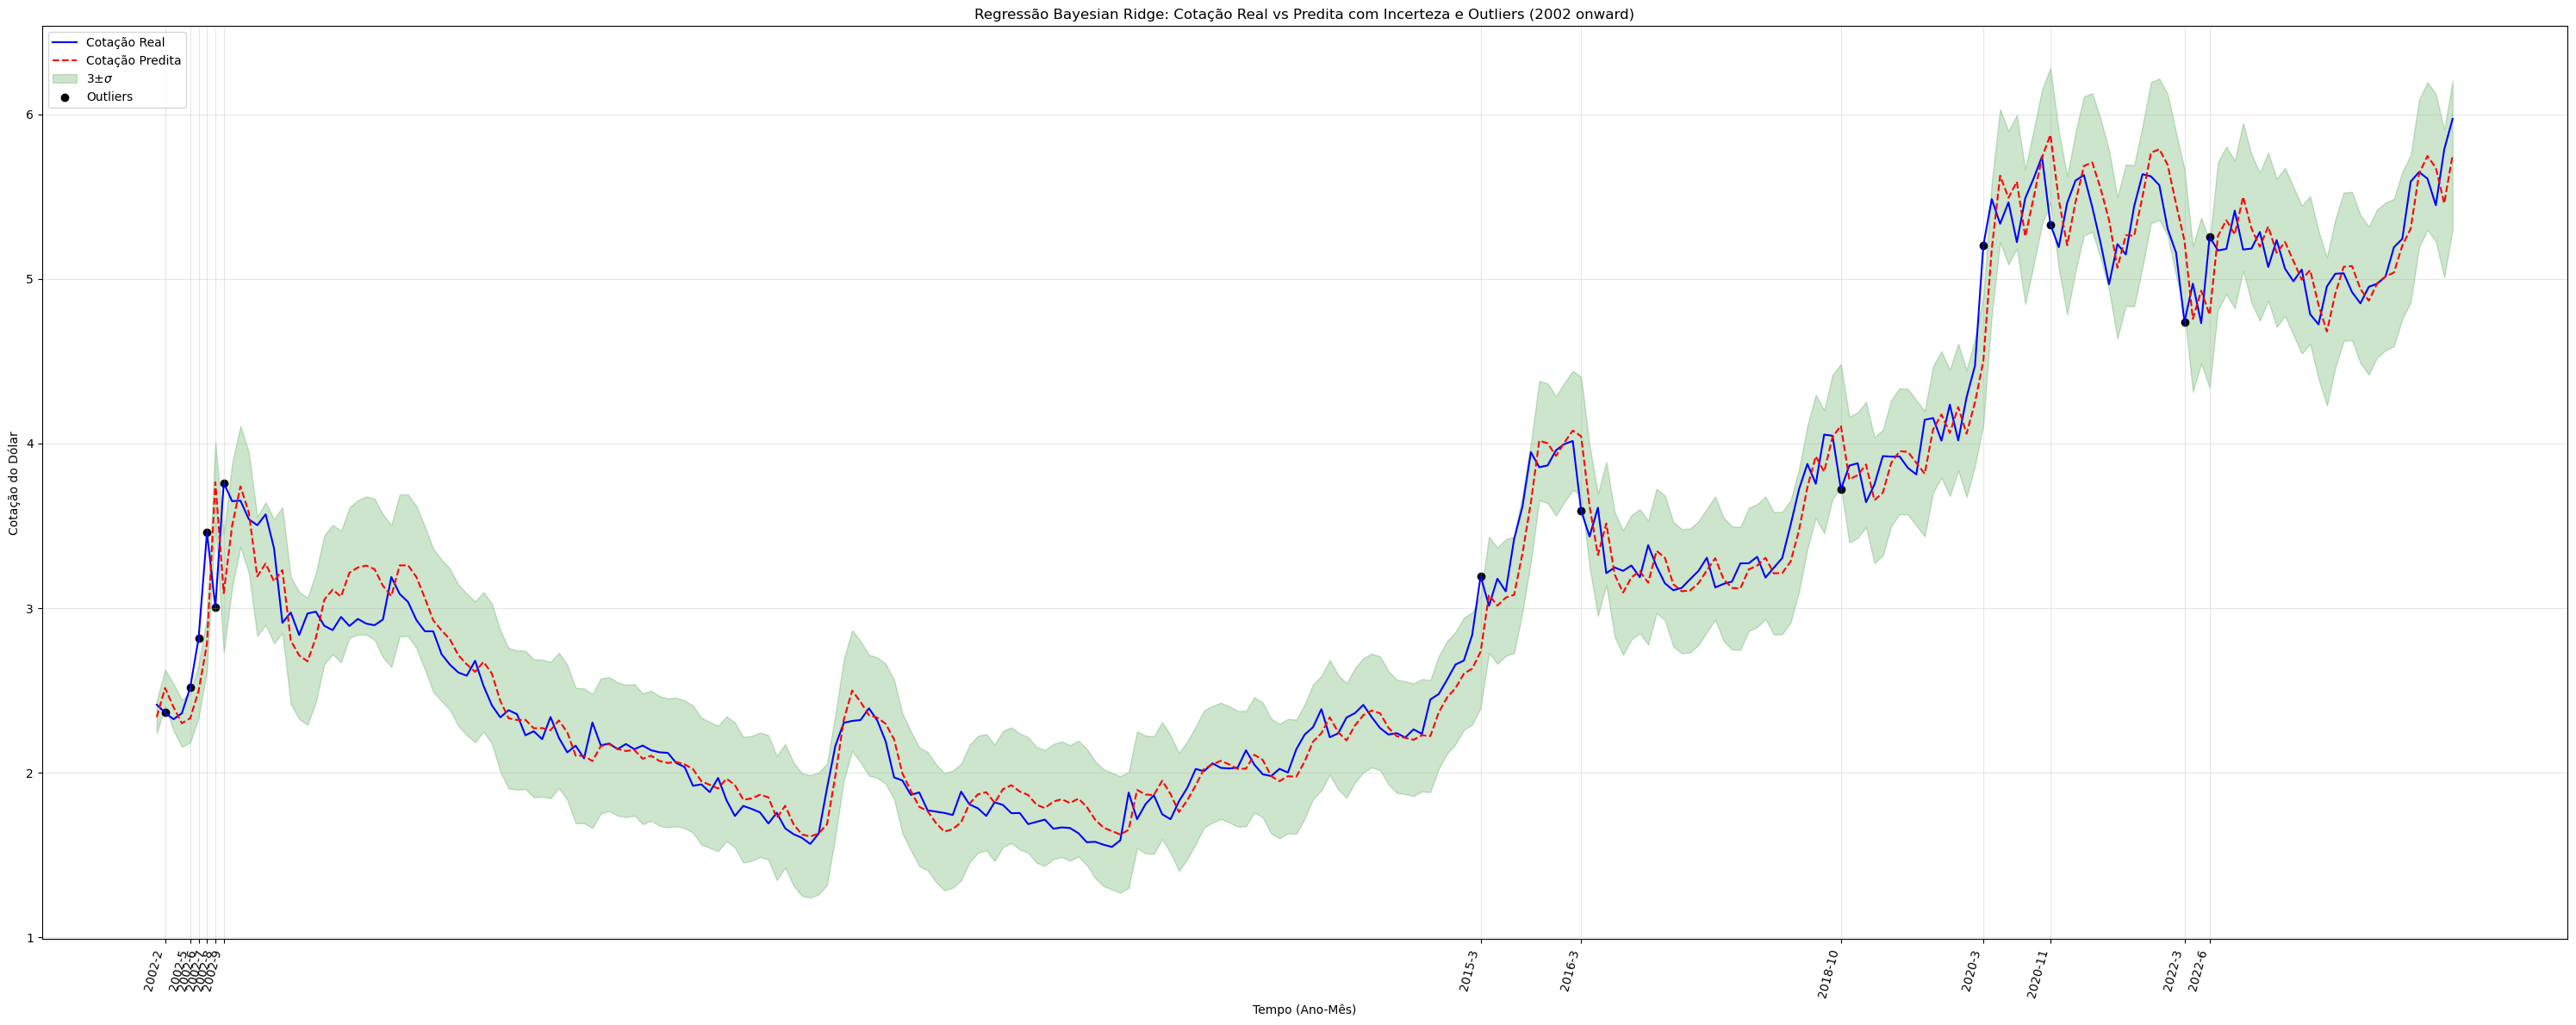

In [8]:
# Load data
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
         'divida_pp', 'fed_rate']]

# Create lag features (n months shift)
n = 6
for shift_val in range(1, n+1):
    for column in ['cotacao', 'ipca_acumulado', 'cpi', 'selic', 'divida_pp', 'fed_rate']:
        column_name = f'{column}_lag{shift_val}'
        df[column_name] = df[column].shift(shift_val)
        df.fillna(df[column].values[0], inplace=True) 

# Define features and target
X = df.drop(columns=['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
                     'divida_pp', 'fed_rate'])
y = df['cotacao']

# Initialize lists for predictions and outliers
predictions_list = []
outliers_list = []

# Train until end of 2001, then predict and retrain monthly
data_ano=2001
train_end_2002 = df[df['ano'] == data_ano].index.max()
current_idx = train_end_2002 + 1  

while current_idx < len(df):
    # Define training data (up to current month - 1)
    X_train = X.iloc[:current_idx]
    y_train = y.iloc[:current_idx]

    # Scale features using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Train Bayesian Ridge model
    br = BayesianRidge()
    br.fit(X_train_scaled, y_train)

    # Prepare data for prediction (current month)
    X_pred = X.iloc[current_idx:current_idx + 1]
    X_pred_scaled = scaler.transform(X_pred)  # Use the same scaler as training data
    y_actual = y.iloc[current_idx]

    # Predict and calculate uncertainty
    y_pred = br.predict(X_pred_scaled)[0]
    residuals = y_train - br.predict(X_train_scaled)
    std_dev = np.std(residuals)
    mul_std = 3  #Uncertainty interval
    lower_bound = y_pred - mul_std * std_dev
    upper_bound = y_pred + mul_std * std_dev

    # Save prediction details
    date = f"{df.loc[current_idx, 'ano']}-{df.loc[current_idx, 'mes']}"
    predictions_list.append({
        'Date': date,
        'True Cotacao': y_actual,
        'Predicted Cotacao': y_pred,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    })

    # Check if actual value is an outlier
    is_outlier = (y_actual < lower_bound) | (y_actual > upper_bound)
    if is_outlier:
        outliers_list.append({
            'Date': date,
            'True Cotacao': y_actual,
            'Predicted Cotacao': y_pred,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound
        })

    # Move to next month
    current_idx += 1

    # Print progress
    if current_idx % 12 == 0:  # Print every year
        date = f"{df.loc[current_idx-1, 'ano']}-{df.loc[current_idx-1, 'mes']}"
        print(f"Processed up to {date}")

# Create DataFrames from lists
predictions_df = pd.DataFrame(predictions_list)
outliers_df = pd.DataFrame(outliers_list)

# Calculate overall metrics
y_pred_all = predictions_df['Predicted Cotacao'].values
y_actual_all = predictions_df['True Cotacao'].values
mae = mean_absolute_error(y_actual_all, y_pred_all)
mape = mean_absolute_percentage_error(y_actual_all, y_pred_all) * 100
rmse = root_mean_squared_error(y_actual_all, y_pred_all)
r2_all = r2_score(y_actual_all, y_pred_all)
outlier_rate = (len(outliers_df) / len(predictions_df)) * 100

# Print results
print(f"Overall RMSE: {rmse:.4f}")
print(f"Overall MAE: {mae:.4f}")
print(f"Overall MAPE: {mape:.2f}%")
print(f"Overall R² score: {r2_all:.2f}")
print(f"Outlier rate: {outlier_rate:.2f}%")
print("\nOutlier Details:")
display(outliers_df)
outliers_df.to_csv(f'Outliers/Bayesian_Regression_Outliers_{mul_std}std.csv',index=False)

# Visualize results
plt.figure(figsize=(30, 12))
plot_dates = predictions_df['Date'].values
plt.plot(plot_dates, y_actual_all, label="Cotação Real", color="blue")
plt.plot(plot_dates, y_pred_all, label="Cotação Predita", color="red", linestyle="--")
plt.fill_between(plot_dates, predictions_df['Lower Bound'], predictions_df['Upper Bound'], 
                 color='green', alpha=0.2, label=rf"{mul_std}$\pm\sigma$")
plt.scatter(outliers_df['Date'], outliers_df['True Cotacao'], 
            color='black', marker='o', label="Outliers")
plt.xticks(outliers_df['Date'].values,rotation=75, ha='right',fontsize=10)
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title(f"Regressão Bayesian Ridge: Cotação Real vs Predita com Incerteza e Outliers ({data_ano+1} onward)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"Plots/Bayesian_Regression_Outliers_{mul_std}std.png", format='png', dpi=200, bbox_inches='tight')
plt.show()